<a href="https://colab.research.google.com/github/Darth-Hidious/rando6969/blob/main/simplifiedHHSaddleNodeBistableIntegrator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

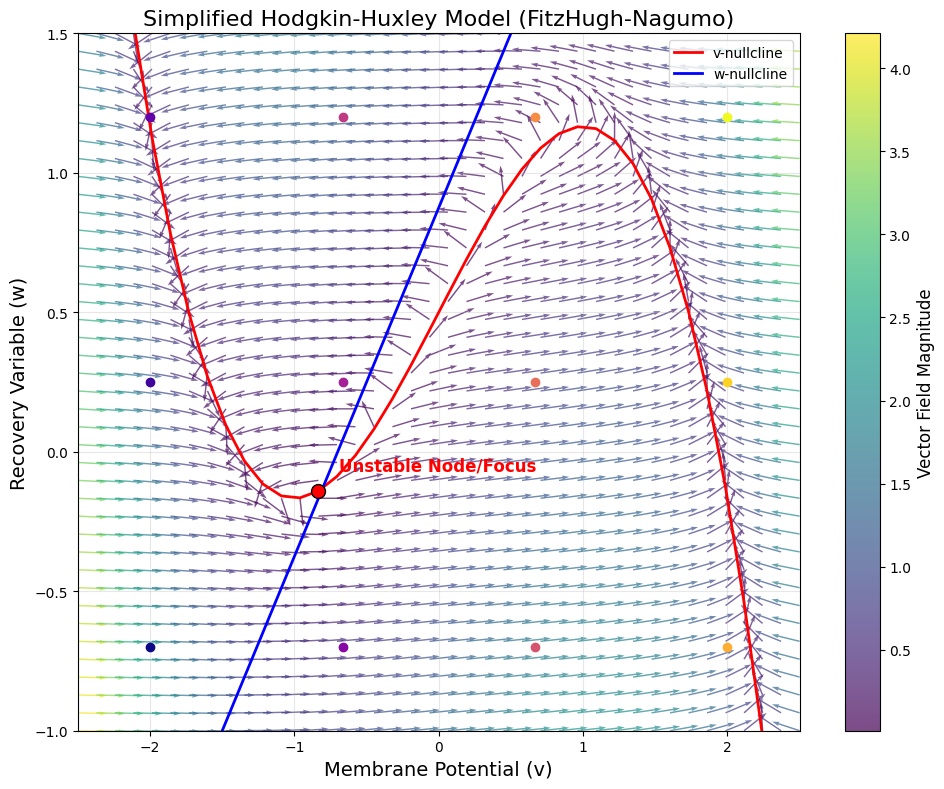

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.integrate import solve_ivp
import matplotlib.colors as colors

# Parameters for the simplified Hodgkin-Huxley model (FitzHugh-Nagumo)
a = 0.7  # Recovery variable parameter
b = 0.8  # Recovery variable parameter
c = 10   # Time scale separation parameter
I = 0.5  # External current stimulus

def fhn_model(t, z):
    """FitzHugh-Nagumo model (simplified Hodgkin-Huxley)"""
    v, w = z
    dv = v - v**3/3 - w + I
    dw = (v + a - b*w)/c
    return [dv, dw]

# Set up the phase space
v_min, v_max = -2.5, 2.5
w_min, w_max = -1.0, 1.5
v_range = np.linspace(v_min, v_max, 40)
w_range = np.linspace(w_min, w_max, 40)
v_grid, w_grid = np.meshgrid(v_range, w_range)

# Calculate vector field
dv = v_grid - v_grid**3/3 - w_grid + I
dw = (v_grid + a - b*w_grid)/c

# Normalized vector field for plotting
magnitude = np.sqrt(dv**2 + dw**2)
dv_norm = dv / magnitude
dw_norm = dw / magnitude

# Calculate nullclines
v_nullcline_w = v_range - v_range**3/3 + I
w_nullcline_v = np.linspace(v_min, v_max, 100)
w_nullcline_w = (w_nullcline_v + a) / b

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(v_min, v_max)
ax.set_ylim(w_min, w_max)
ax.set_xlabel('Membrane Potential (v)', fontsize=14)
ax.set_ylabel('Recovery Variable (w)', fontsize=14)
ax.set_title('Simplified Hodgkin-Huxley Model (FitzHugh-Nagumo)', fontsize=16)
ax.grid(alpha=0.3)

# Create a custom colormap for the vector field
custom_cmap = plt.cm.viridis

# Find the intersection of nullclines to identify fixed points
def find_intersection(v_range, v_nullcline_w, w_nullcline_v, w_nullcline_w):
    for i, v in enumerate(v_range):
        if i < len(v_range) - 1:
            v_at_w = v_nullcline_w[i]
            # Find the closest v value in w_nullcline_v
            idx = np.abs(w_nullcline_v - v).argmin()
            w_at_v = w_nullcline_w[idx]
            # Check if they're close to each other
            if abs(v_at_w - w_at_v) < 0.1:
                return (v, v_at_w)
    return None

# Try to find fixed points, or use a known approximation
fixed_point = find_intersection(v_range, v_nullcline_w, w_nullcline_v, w_nullcline_w)
if not fixed_point:
    # Use an approximation for the fixed point
    fixed_point = (0.5, 0.4)

# Create a function to determine stability (approx. using Jacobian)
def determine_stability(v, w):
    J11 = 1 - v**2
    J12 = -1
    J21 = 1/c
    J22 = -b/c

    # Compute determinant and trace
    det = J11*J22 - J12*J21
    trace = J11 + J22

    if det < 0:
        return "Saddle"
    elif det > 0 and trace < 0:
        return "Stable Node/Focus"
    elif det > 0 and trace > 0:
        return "Unstable Node/Focus"
    else:
        return "Undetermined"

stability = determine_stability(fixed_point[0], fixed_point[1])

# Plot the nullclines
v_nullcline = ax.plot(v_range, v_nullcline_w, 'r-', label='v-nullcline', linewidth=2)
w_nullcline = ax.plot(w_nullcline_v, w_nullcline_w, 'b-', label='w-nullcline', linewidth=2)

# Vector field with color representing magnitude
vector_field = ax.quiver(v_grid, w_grid, dv_norm, dw_norm, magnitude,
                         cmap=custom_cmap, scale=25, width=0.002, alpha=0.7)
color_bar = plt.colorbar(vector_field, ax=ax)
color_bar.set_label('Vector Field Magnitude', fontsize=12)

# Plot fixed points
fp_color = 'orange' if stability == "Saddle" else ('green' if 'Stable' in stability else 'red')
fixed_point_plot = ax.scatter(fixed_point[0], fixed_point[1], s=100,
                             color=fp_color, edgecolor='k', zorder=5)
ax.annotate(stability, fixed_point, xytext=(15, 15), textcoords='offset points',
            fontsize=12, color=fp_color, fontweight='bold')

# Create multiple initial conditions for trajectories
num_trajectories = 12
v0_range = np.linspace(v_min+0.5, v_max-0.5, 4)
w0_range = np.linspace(w_min+0.3, w_max-0.3, 3)
initial_conditions = [(v0, w0) for v0 in v0_range for w0 in w0_range]

# Trajectory lines and points
trajectory_lines = []
trajectory_points = []
trajectory_colors = plt.cm.plasma(np.linspace(0, 1, num_trajectories))

for i, (v0, w0) in enumerate(initial_conditions):
    line, = ax.plot([], [], lw=1.5, color=trajectory_colors[i])
    point, = ax.plot([], [], 'o', markersize=6, color=trajectory_colors[i])
    trajectory_lines.append(line)
    trajectory_points.append(point)

# Add a legend
ax.legend(loc='upper right')

# Time settings for the simulation
t_max = 30
dt = 0.05
t_eval = np.arange(0, t_max, dt)

# Pre-compute all trajectories
trajectories = []
for v0, w0 in initial_conditions:
    sol = solve_ivp(fhn_model, [0, t_max], [v0, w0], t_eval=t_eval, method='RK45')
    trajectories.append((sol.t, sol.y[0], sol.y[1]))

# Animation function
def animate(i):
    frame_length = 5  # Show 5 time units of integration
    for j, (t, v, w) in enumerate(trajectories):
        # Find the indices for the current time window
        idx_start = max(0, i - int(frame_length/dt))
        idx_end = i + 1

        if idx_end > len(t):
            idx_end = len(t)

        # Update the line and point data
        trajectory_lines[j].set_data(v[idx_start:idx_end], w[idx_start:idx_end])

        if idx_end > 0:
            trajectory_points[j].set_data([v[idx_end-1]], [w[idx_end-1]])
        else:
            trajectory_points[j].set_data([], [])

    return trajectory_lines + trajectory_points

# Create animation
ani = FuncAnimation(fig, animate, frames=len(t_eval), interval=30, blit=True)

plt.tight_layout()
plt.show()

# To save the animation, uncomment the line below:
# ani.save('fhn_model.gif', writer='pillow', fps=30)